In [1]:
import os
import json
import statistics
from src.najdi_rok import najdi_rok
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

In [53]:
df = pd.read_parquet(os.path.join("data","cnb_vyber.parquet"))
df = df.explode('008')
df['rok'] = df['008'].apply(lambda x: najdi_rok(x))

In [4]:
df = df.sort_values(by='rok')

In [5]:
test = ['Errol','Šikmý kostel','Letnice','Toužimský','Drak na polní cestě','Dům v Matoušově','Flora','koupališti Úštěk','Jů a Hele','Antropocennosti','Český bestiář','Tahle kniha ti změní život','Poslední léto']

In [6]:
for t in test:
    print(t.upper())
    print(df[df['245_a'].str.contains(t,na=False)][['245_a','rok']].tail(3).to_string())

ERROL
Empty DataFrame
Columns: [245_a, rok]
Index: []
ŠIKMÝ KOSTEL
                         245_a     rok
001                                   
nkc20213304795  Šikmý kostel :  2020.0
LETNICE
                    245_a     rok
001                              
nkc20233492812  Letnice :  2013.0
nkc20183000204  Letnice /  2017.0
nkc20243588089  Letnice /  2024.0
TOUŽIMSKÝ
                                                       245_a     rok
001                                                                 
nkc20193065342  Reklama nakladatelství Toužimský & Moravec :  2019.0
nkc20243637414                         Toužimský & Moravec :  2024.0
DRAK NA POLNÍ CESTĚ
                                245_a     rok
001                                          
nkc20243634713  Drak na polní cestě /  2024.0
DŮM V MATOUŠOVĚ
                                  245_a     rok
001                                            
nkc20243599890  Dům v Matoušově ulici /  2024.0
FLORA
                       245_a

In [58]:
filtr1 = df[df['rok'] == 2024]

In [60]:
filtr1 = filtr1.explode('041_h')

In [62]:
filtr1 = filtr1[(filtr1['041_h'].isnull()) | (filtr1['041_h'] == 'cze')]

In [64]:
isbns = []
isbns += [str(x).replace('-','').strip() for x in filtr1.explode('020_a')['020_a'].to_list()]

In [68]:
len(isbns)

4694

In [66]:
filtr2 = df[df['rok'] >= 2020]
filtr2 = filtr2.explode('072_a')
filtr2 = filtr2[filtr2['072_a'] == '821.162.3-3']

In [70]:
isbns += [str(x).replace('-','').strip() for x in filtr2.explode('020_a')['020_a'].to_list()]

In [72]:
len(isbns)

12481

In [74]:
df = pd.read_json(os.path.join("data_raw","martinus_raw.json"))

In [76]:
isbns += df[df['M_rok_vydání'] == 2024]['M_isbn'].to_list()
isbns = list(set(isbns))
len(isbns)

11769

In [78]:
with open(os.path.join("data_raw", "rucni_sledovat.json"), "r") as rucni:
    rucni_sledovat = json.load(rucni)
isbns += rucni_sledovat
isbns = list(set(isbns))
len(isbns)

11798

In [80]:
with open(os.path.join("data_raw","sledovat_vanoce_2024.json"), "w+", encoding="utf-8") as megadump:
    megadump.write(json.dumps(isbns))

## Goodreads

In [179]:
import re
def spravnyrok(published):
    rok = re.search(r"\d{4}",str(published))
    if rok:
        if rok.group(0) == '2024':
            return True
        else:
            return False
    else:
        return True

In [181]:
gr1 = pd.read_csv(os.path.join("data","goodreads-hodnoceni-extra.csv"))
gr2 = pd.read_csv(os.path.join("data","goodreads-hodnoceni.csv"))
gr = pd.concat([gr1, gr2])
gr['GR_date'] = pd.to_datetime(gr['GR_date'])
gr = gr.sort_values(by='GR_date')
gr['GR_isbn'] = gr['GR_isbn'].astype(str).apply(lambda x: x.replace(".0",""))
gr = gr[gr['GR_ratings_count'] != 0]
gr = gr.drop_duplicates(subset=["GR_isbn"], keep='last')

In [183]:
gr['spravny'] = gr['GR_published'].apply(lambda x: spravnyrok(x))
gr = gr[gr['spravny'] == True]

In [185]:
gr.groupby('spravny').size()

spravny
True    501
dtype: int64

In [24]:
gr.groupby('GR_published').size().nlargest(10)

GR_published
January 1, 2024     153
April 1, 2024        10
May 1, 2024           8
March 1, 2024         7
May 6, 2024           7
February 1, 2024      6
April 18, 2024        5
June 20, 2024         5
March 20, 2024        5
April 11, 2024        4
dtype: int64

In [25]:
gr = gr[gr['GR_published'].str.contains('2024',na=False) | ((~gr['GR_published'].str.contains('2023',na=False)) & (~gr['GR_published'].str.contains('2022',na=False)))]

In [26]:
gr['GR_title'].nunique()

374

In [187]:
for t in test:
    print(t.upper())
    print(gr[gr['GR_title'].str.contains(t)])

ERROL
Empty DataFrame
Columns: [GR_isbn, GR_date, GR_title, GR_rating, GR_ratings_count, GR_reviews, GR_published, GR_1_stars, GR_2_stars, GR_3_stars, GR_4_stars, GR_5_stars, GR_pages, GR_format, spravny]
Index: []
ŠIKMÝ KOSTEL
            GR_isbn             GR_date  \
5997  9788088362166 2024-12-02 23:51:00   

                                               GR_title  GR_rating  \
5997  Šikmý kostel 3: románová kronika ztraceného mě...       4.68   

      GR_ratings_count  GR_reviews    GR_published  GR_1_stars  GR_2_stars  \
5997             653.0        53.0  April 18, 2024         0.0         0.0   

      GR_3_stars  GR_4_stars  GR_5_stars  GR_pages  GR_format  spravny  
5997        31.0       149.0       473.0     696.0  hardcover     True  
LETNICE
            GR_isbn             GR_date                    GR_title  \
5954  9788076374638 2024-12-02 23:43:38  Letnice by Miroslav Hlaučo   

      GR_rating  GR_ratings_count  GR_reviews     GR_published  GR_1_stars  \
5954       4

In [28]:
gr[~gr['GR_published'].str.contains('2024',na=False)].sort_values(by='GR_ratings_count', ascending=False).head(20)

,GR_isbn,GR_date,GR_title,GR_rating,GR_ratings_count,GR_reviews,GR_published,GR_1_stars,GR_2_stars,GR_3_stars,GR_4_stars,GR_5_stars,GR_pages,GR_format,spravny
2993,9783899198416,2024-11-12 01:57:04,The Metamorphosis by Franz Kafka,4.1,10.0,1.0,NaN,0.0,0.0,3.0,3.0,4.0,NaN,NaN,True
3151,9788024297491,2024-11-29 15:30:54,Japonskou krajinou a kulturou by Denisa Vostrá,3.0,2.0,0.0,NaN,0.0,0.0,2.0,0.0,0.0,248.0,NaN,True
1809,9788024951652,2024-04-19 22:33:07,Rozinky v blátě by David Jan Novotný,5.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
3214,9783899197655,2024-11-29 15:43:42,Franz Kafka by unknown author,3.0,1.0,0.0,NaN,0.0,0.0,1.0,0.0,0.0,NaN,NaN,True
3216,9783899197679,2024-11-29 15:43:53,Franz Kafka by unknown author,3.0,1.0,0.0,NaN,0.0,0.0,1.0,0.0,0.0,NaN,NaN,True


In [189]:
gr[gr['GR_title'].str.contains('Flor')]

,GR_isbn,GR_date,GR_title,GR_rating,GR_ratings_count,GR_reviews,GR_published,GR_1_stars,GR_2_stars,GR_3_stars,GR_4_stars,GR_5_stars,GR_pages,GR_format,spravny
6929,9788025744697,2024-12-03 02:06:35,"Florencie, moje (sebe)láska by Veronika Vrzalová",4.45,11.0,3.0,"June 20, 2024",0.0,1.0,0.0,3.0,7.0,360.0,paperback,True


In [30]:
gr['GR_title'].nunique()

374

In [31]:
gr[gr['GR_title'].str.contains('Flor')]

,GR_isbn,GR_date,GR_title,GR_rating,GR_ratings_count,GR_reviews,GR_published,GR_1_stars,GR_2_stars,GR_3_stars,GR_4_stars,GR_5_stars,GR_pages,GR_format,spravny
3174,9788025744697,2024-11-29 15:36:08,"Florencie, moje (sebe)láska by Veronika Vrzalová",4.5,10.0,3.0,"June 20, 2024",0.0,1.0,0.0,2.0,7.0,360.0,paperback,True


In [32]:
gr[gr['GR_ratings_count'] > 20].sort_values(by='GR_ratings_count',ascending=False).head(100)

,GR_isbn,GR_date,GR_title,GR_rating,GR_ratings_count,GR_reviews,GR_published,GR_1_stars,GR_2_stars,GR_3_stars,GR_4_stars,GR_5_stars,GR_pages,GR_format,spravny
23968,9788088362166,2024-11-25 02:10:03,Šikmý kostel 3: románová kronika ztraceného mě...,4.68,639.0,52.0,"April 18, 2024",0.0,0.0,31.0,142.0,466.0,NaN,NaN,True
3073,9788011048396,2024-11-29 15:15:36,Zuzana Čaputová: Neztratit se sama sobě by Eri...,4.78,530.0,66.0,"June 15, 2024",0.0,1.0,16.0,83.0,430.0,248.0,hardcover,True
3259,9788090917422,2024-11-29 15:54:27,"Stačí mávnout křídly (Stačí mávnout křídly, #1...",4.48,445.0,88.0,"June 20, 2024",5.0,6.0,27.0,141.0,266.0,336.0,paperback,True
15565,9788090917408,2024-09-23 01:55:35,"Stačí mávnout křídly (Stačí mávnout křídly, #1...",4.48,396.0,84.0,"May 15, 2024",4.0,6.0,24.0,124.0,238.0,NaN,NaN,True
3112,9788026726463,2024-11-29 15:22:04,Odvaha by Markéta Lukášková,4.21,393.0,43.0,"May 16, 2024",4.0,14.0,51.0,152.0,172.0,280.0,hardcover,True
23996,9788076619340,2024-11-25 02:14:47,Můžeš říct: Miluju tě by Nofreeusernames,3.84,334.0,56.0,"May 6, 2024",8.0,9.0,88.0,152.0,77.0,NaN,NaN,True
3241,9788027520459,2024-11-29 15:46:43,Ignis fatuus by Petra Klabouchová,4.17,293.0,60.0,"June 4, 2024",1.0,13.0,46.0,109.0,124.0,336.0,hardcover,True
23612,9788025367094,2024-11-25 01:19:14,Lásky čas by Adéla Rosípalová,4.41,287.0,63.0,"April 18, 2024",3.0,3.0,23.0,101.0,157.0,NaN,NaN,True
3120,9788025368299,2024-11-29 15:22:58,Zlomky nekonečna by Adéla Rosípalová,4.31,252.0,40.0,"July 25, 2024",3.0,10.0,25.0,83.0,131.0,336.0,paperback,True
24174,9788076619593,2024-11-25 02:49:19,Národní opruzení 2 by Karolína Zoe Meixnerová,4.12,183.0,27.0,"May 1, 2024",0.0,10.0,29.0,73.0,71.0,NaN,NaN,True


In [128]:
gr[(gr['GR_5_stars'] > gr['GR_4_stars']) & (gr['GR_4_stars'] > gr['GR_3_stars']) & (gr['GR_3_stars'] > gr['GR_2_stars']) & (gr['GR_2_stars'] > gr['GR_1_stars'])]

,GR_isbn,GR_date,GR_title,GR_rating,GR_ratings_count,GR_reviews,GR_published,GR_1_stars,GR_2_stars,GR_3_stars,GR_4_stars,GR_5_stars,GR_pages,GR_format,tyden
22531,9788076374638,2024-11-18 01:15:49,Letnice by Miroslav Hlaučo,4.26,105.0,26.0,"January 1, 2024",1.0,2.0,13.0,42.0,47.0,NaN,NaN,32
23601,9788076374638,2024-11-25 01:18:19,Letnice by Miroslav Hlaučo,4.25,108.0,26.0,"January 1, 2024",1.0,2.0,14.0,43.0,48.0,NaN,NaN,33


In [33]:
gr[gr['GR_published'].isnull()]

,GR_isbn,GR_date,GR_title,GR_rating,GR_ratings_count,GR_reviews,GR_published,GR_1_stars,GR_2_stars,GR_3_stars,GR_4_stars,GR_5_stars,GR_pages,GR_format,spravny
1809,9788024951652,2024-04-19 22:33:07,Rozinky v blátě by David Jan Novotný,5.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2993,9783899198416,2024-11-12 01:57:04,The Metamorphosis by Franz Kafka,4.1,10.0,1.0,NaN,0.0,0.0,3.0,3.0,4.0,NaN,NaN,True
3151,9788024297491,2024-11-29 15:30:54,Japonskou krajinou a kulturou by Denisa Vostrá,3.0,2.0,0.0,NaN,0.0,0.0,2.0,0.0,0.0,248.0,NaN,True
3214,9783899197655,2024-11-29 15:43:42,Franz Kafka by unknown author,3.0,1.0,0.0,NaN,0.0,0.0,1.0,0.0,0.0,NaN,NaN,True
3216,9783899197679,2024-11-29 15:43:53,Franz Kafka by unknown author,3.0,1.0,0.0,NaN,0.0,0.0,1.0,0.0,0.0,NaN,NaN,True


In [34]:
gr[gr['GR_ratings_count'] > 20].sort_values(by='GR_rating',ascending=False).head(100)

,GR_isbn,GR_date,GR_title,GR_rating,GR_ratings_count,GR_reviews,GR_published,GR_1_stars,GR_2_stars,GR_3_stars,GR_4_stars,GR_5_stars,GR_pages,GR_format,spravny
24209,9788027913206,2024-11-25 02:54:45,Ester by Markéta Prášková,4.83,24.0,4.0,"January 1, 2024",0.0,0.0,0.0,4.0,20.0,NaN,NaN,True
3073,9788011048396,2024-11-29 15:15:36,Zuzana Čaputová: Neztratit se sama sobě by Eri...,4.78,530.0,66.0,"June 15, 2024",0.0,1.0,16.0,83.0,430.0,248.0,hardcover,True
23968,9788088362166,2024-11-25 02:10:03,Šikmý kostel 3: románová kronika ztraceného mě...,4.68,639.0,52.0,"April 18, 2024",0.0,0.0,31.0,142.0,466.0,NaN,NaN,True
3109,9788090917439,2024-11-29 15:21:40,"Pilná jako včelka (Stačí mávnout křídly, #2) b...",4.66,35.0,14.0,"October 9, 2024",0.0,0.0,0.0,12.0,23.0,352.0,paperback,True
24238,9788088623007,2024-11-25 03:01:46,Na neVěčné časy by Tereza Kadečková,4.64,74.0,21.0,"February 14, 2024",0.0,2.0,5.0,11.0,56.0,NaN,NaN,True
23928,9788088635550,2024-11-25 02:02:32,Smečka by Jiří Sivok,4.53,30.0,15.0,"April 29, 2024",0.0,0.0,2.0,10.0,18.0,NaN,NaN,True
15565,9788090917408,2024-09-23 01:55:35,"Stačí mávnout křídly (Stačí mávnout křídly, #1...",4.48,396.0,84.0,"May 15, 2024",4.0,6.0,24.0,124.0,238.0,NaN,NaN,True
3259,9788090917422,2024-11-29 15:54:27,"Stačí mávnout křídly (Stačí mávnout křídly, #1...",4.48,445.0,88.0,"June 20, 2024",5.0,6.0,27.0,141.0,266.0,336.0,paperback,True
3106,9788090917415,2024-11-29 15:21:26,"Hodina hromu (Století Olomouce, #2) by Lenka P...",4.46,46.0,13.0,"May 15, 2024",0.0,2.0,1.0,17.0,26.0,280.0,hardcover,True
24267,9788024776699,2024-11-25 03:06:06,Kdo je tu šéf? by Petra Schier,4.43,35.0,10.0,"May 31, 2024",0.0,2.0,2.0,10.0,21.0,NaN,NaN,True


In [35]:
gr = gr.replace({"mass market paperback":"paperback"})

In [36]:
gr[gr['GR_pages'] >= gr['GR_pages'].median()].groupby("GR_format")['GR_rating'].mean()

GR_format
hardcover    3.819783
paperback    3.996905
Name: GR_rating, dtype: float64

In [37]:
gr['GR_pages'].median()

264.0

In [38]:
gr[gr['GR_pages'] > gr['GR_pages'].median()][['GR_pages','GR_rating']].corr()

,GR_pages,GR_rating
GR_pages,1.0000,0.1454
GR_rating,0.1454,1.0000


In [39]:
gr[['GR_1_stars','GR_2_stars','GR_3_stars','GR_4_stars','GR_5_stars']].corr()

,GR_1_stars,GR_2_stars,GR_3_stars,GR_4_stars,GR_5_stars
GR_1_stars,1.000000,0.645673,0.613224,0.537202,0.298242
GR_2_stars,0.645673,1.000000,0.723636,0.574272,0.295776
GR_3_stars,0.613224,0.723636,1.000000,0.852128,0.515222
GR_4_stars,0.537202,0.574272,0.852128,1.000000,0.803125
GR_5_stars,0.298242,0.295776,0.515222,0.803125,1.000000


In [40]:
gr['extremy'] = gr['GR_5_stars'] / gr['GR_1_stars']

In [41]:
gr.groupby('GR_published').size()

GR_published
April 1, 2024          10
April 11, 2024          4
April 12, 2024          1
April 17, 2024          4
April 18, 2024          5
April 2, 2024           1
April 22, 2024          1
April 23, 2024          2
April 24, 2024          2
April 26, 2024          1
April 29, 2024          2
April 3, 2024           1
April 30, 2024          2
April 4, 2024           2
April 8, 2024           3
August 14, 2024         1
August 15, 2024         1
August 26, 2024         3
August 28, 2024         2
August 29, 2024         3
August 31, 2024         1
August 5, 2024          2
February 1, 2024        6
February 12, 2024       3
February 14, 2024       3
February 15, 2024       1
February 19, 2024       3
February 2, 2024        1
February 21, 2024       1
February 22, 2024       3
February 23, 2024       1
February 26, 2024       4
February 29, 2024       2
February 7, 2024        2
February 9, 2024        1
January 1, 2024       153
January 15, 2024        1
January 17, 2024        1

In [42]:
gr[gr['GR_ratings_count'] > 50].sort_values(by='extremy')

,GR_isbn,GR_date,GR_title,GR_rating,GR_ratings_count,GR_reviews,GR_published,GR_1_stars,GR_2_stars,GR_3_stars,GR_4_stars,GR_5_stars,GR_pages,GR_format,spravny,extremy
3223,9788025369425,2024-11-29 15:44:36,Ocelová liga by Adéla Rosípalová,3.51,76.0,24.0,"August 29, 2024",3.0,6.0,26.0,31.0,10.0,288.0,paperback,True,3.333333
15318,9788027740734,2024-09-23 01:13:06,Woodhill by Eleanor Corvin,3.79,132.0,30.0,"April 17, 2024",6.0,10.0,29.0,48.0,39.0,NaN,NaN,True,6.500000
3130,9788075885937,2024-11-29 15:26:19,Kronika konce světa by Shigor Birdman,3.75,72.0,7.0,"June 18, 2024",2.0,7.0,13.0,35.0,15.0,320.0,hardcover,True,7.500000
23962,9788027742547,2024-11-25 02:07:25,"Zvrhlá hra (Alfa & Omega, #1) by Tess M. Puffrová",3.71,108.0,11.0,"January 1, 2024",4.0,8.0,33.0,33.0,30.0,NaN,NaN,True,7.500000
23996,9788076619340,2024-11-25 02:14:47,Můžeš říct: Miluju tě by Nofreeusernames,3.84,334.0,56.0,"May 6, 2024",8.0,9.0,88.0,152.0,77.0,NaN,NaN,True,9.625000
24216,9788027520473,2024-11-25 02:55:07,Pacanka by Klára Elšíková,3.71,69.0,9.0,"January 1, 2024",1.0,0.0,28.0,29.0,11.0,NaN,NaN,True,11.000000
24170,9788024293233,2024-11-25 02:49:07,Za pět minut zvoní by Michaela Merglová,3.73,80.0,12.0,"January 1, 2024",1.0,2.0,27.0,38.0,12.0,NaN,NaN,True,12.000000
24156,9788026726029,2024-11-25 02:45:39,Dceřina kletba by Tereza Bartošová,3.90,73.0,15.0,"February 1, 2024",1.0,4.0,15.0,34.0,19.0,NaN,NaN,True,19.000000
3173,9788027801633,2024-11-29 15:33:40,Přístav u řeky Styx by Pavel Fritz,4.11,53.0,6.0,"February 19, 2024",1.0,1.0,11.0,18.0,22.0,456.0,paperback,True,22.000000
3065,9788024298160,2024-11-29 15:14:42,Tři Sekery by Kateřina Surmanová,4.04,92.0,18.0,"June 1, 2024",1.0,5.0,15.0,39.0,32.0,336.0,paperback,True,32.000000


<Axes: xlabel='GR_pages', ylabel='GR_rating'>

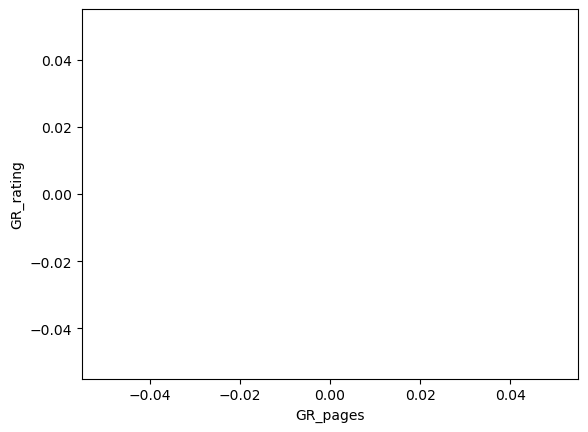

In [126]:
gr[(gr['GR_pages'] > gr['GR_pages'].median())].plot.scatter(x="GR_pages",y="GR_rating")

In [44]:
gr = pd.read_csv(os.path.join("data","goodreads-hodnoceni.csv"))
gr['GR_date'] = pd.to_datetime(gr['GR_date'])
gr = gr.sort_values(by='GR_date')
gr['GR_isbn'] = gr['GR_isbn'].astype(str).apply(lambda x: x.replace(".0",""))

In [45]:
gr = gr.drop_duplicates(subset=["GR_isbn"], keep='last')

In [46]:
gr = gr[gr['GR_isbn'].isin(isbns)]

In [47]:
len(gr)

377

In [48]:
gr['GR_ratings_count'].quantile([0.1,0.25,0.5,0.75,0.8,0.9])

0.10     0.0
0.25     1.0
0.50     4.0
0.75    13.0
0.80    16.0
0.90    42.4
Name: GR_ratings_count, dtype: float64

In [49]:
gr[gr['GR_ratings_count'] > 20].sort_values(by='GR_rating',ascending=False).head(100)

,GR_isbn,GR_date,GR_title,GR_rating,GR_ratings_count,GR_reviews,GR_published,GR_1_stars,GR_2_stars,GR_3_stars,GR_4_stars,GR_5_stars,GR_pages,GR_format
24209,9788027913206,2024-11-25 02:54:45,Ester by Markéta Prášková,4.83,24.0,4.0,"January 1, 2024",0.0,0.0,0.0,4.0,20.0,NaN,NaN
23762,9788011048396,2024-11-25 01:43:05,Zuzana Čaputová: Neztratit se sama sobě by Eri...,4.78,524.0,66.0,"June 15, 2024",0.0,1.0,16.0,82.0,425.0,NaN,NaN
23968,9788088362166,2024-11-25 02:10:03,Šikmý kostel 3: románová kronika ztraceného mě...,4.68,639.0,52.0,"April 18, 2024",0.0,0.0,31.0,142.0,466.0,NaN,NaN
24238,9788088623007,2024-11-25 03:01:46,Na neVěčné časy by Tereza Kadečková,4.64,74.0,21.0,"February 14, 2024",0.0,2.0,5.0,11.0,56.0,NaN,NaN
24166,9788090917422,2024-11-25 02:48:41,"Stačí mávnout křídly (Stačí mávnout křídly, #1...",4.48,444.0,88.0,"June 20, 2024",5.0,6.0,27.0,141.0,265.0,NaN,NaN
15565,9788090917408,2024-09-23 01:55:35,"Stačí mávnout křídly (Stačí mávnout křídly, #1...",4.48,396.0,84.0,"May 15, 2024",4.0,6.0,24.0,124.0,238.0,NaN,NaN
24027,9788090917415,2024-11-25 02:19:19,"Hodina hromu (Století Olomouce, #2) by Lenka P...",4.44,45.0,13.0,"May 15, 2024",0.0,2.0,1.0,17.0,25.0,NaN,NaN
23622,9788072605880,2024-11-25 01:19:50,Píseň L. by Veronika Opatřilová,4.41,124.0,21.0,"February 23, 2024",1.0,3.0,18.0,24.0,78.0,NaN,NaN
23612,9788025367094,2024-11-25 01:19:14,Lásky čas by Adéla Rosípalová,4.41,287.0,63.0,"April 18, 2024",3.0,3.0,23.0,101.0,157.0,NaN,NaN
15991,9788025736388,2024-09-23 03:20:43,"Vrstva ticha (Mycelium, #6) by Vilma Kadlečková",4.38,161.0,23.0,"February 29, 2024",0.0,1.0,20.0,57.0,83.0,NaN,NaN


## Klesá to?

In [82]:
gr = pd.read_csv(os.path.join("data","goodreads-hodnoceni.csv"))
gr['GR_date'] = pd.to_datetime(gr['GR_date'])
gr = gr.sort_values(by='GR_date')
gr['GR_isbn'] = gr['GR_isbn'].astype(str).apply(lambda x: x.replace(".0",""))
gr = gr[gr['GR_isbn'].isin(isbns)]
gr = gr[gr['GR_rating'] != 0]         
kolikrat = gr.groupby('GR_isbn').size()
kolikrat = kolikrat[kolikrat >= 30]
print(len(kolikrat))
kolikrat = kolikrat.index.to_list()
gr = gr[gr['GR_isbn'].isin(kolikrat)]
gr['tyden'] = gr.groupby('GR_isbn').cumcount() + 1

283


In [159]:
hodne_hodnocene = gr.groupby('GR_isbn').size()
hodne_hodnocene = hodne_hodnocene[hodne_hodnocene >= 10].index.to_list()

In [161]:
hodne_hodnocene = gr[(gr['GR_ratings_count'] > 100) & (gr['GR_isbn'].isin(hodne_hodnocene))]['GR_isbn'].drop_duplicates().to_list()

In [163]:
len(hodne_hodnocene)

33

In [165]:
gr[gr['GR_isbn'].isin(hodne_hodnocene)].groupby('tyden')['GR_rating'].median().head(30)

tyden
1     4.09
2     4.08
3     4.08
4     4.06
5     4.04
6     4.02
7     4.03
8     4.02
9     4.02
10    4.02
11    4.02
12    4.02
13    4.02
14    4.01
15    4.02
16    4.02
17    4.03
18    4.03
19    4.03
20    4.01
21    4.01
22    4.00
23    4.00
24    4.00
25    4.00
26    3.99
27    4.00
28    4.00
29    4.00
30    4.00
Name: GR_rating, dtype: float64

In [171]:
gr['deleno_deseti'] = gr['GR_ratings_count'] / 10
gr['deleno_deseti'] = gr['deleno_deseti'].astype(int)

In [173]:
gr.sample(5)

,GR_isbn,GR_date,GR_title,GR_rating,GR_ratings_count,GR_reviews,GR_published,GR_1_stars,GR_2_stars,GR_3_stars,GR_4_stars,GR_5_stars,GR_pages,GR_format,tyden,deleno_deseti
20670,9788027520091,2024-10-28 02:22:42,Těžké duše by Iva Hadj Moussa,3.91,102.0,11.0,"February 21, 2024",1.0,5.0,25.0,42.0,29.0,NaN,NaN,30,10
5950,9788024287478,2024-06-17 03:04:51,Zlé časy by Michal Březina,3.00,4.0,2.0,"February 1, 2023",NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,0
6108,9788088067856,2024-06-17 03:18:10,Rovnováha by Petr Švec,4.17,6.0,2.0,"May 22, 2023",NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,0
2500,9788073358495,2024-05-06 10:59:49,"Tam, kde nejsi by Lenka Sadílková",3.20,5.0,0.0,"March 1, 2023",NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,0
7384,9788074762666,2024-07-01 03:15:28,Úterní poledne by Tomáš Král,4.00,1.0,0.0,"January 1, 2023",NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,0


In [177]:
gr[gr['GR_isbn'].isin(hodne_hodnocene)].groupby("deleno_deseti")['GR_rating'].median().head(20)

deleno_deseti
0     4.250
1     4.370
2     4.375
3     4.290
4     3.840
5     3.865
6     3.870
7     4.080
8     4.030
9     3.710
10    3.745
11    3.740
12    3.765
13    3.810
14    4.010
15    3.950
16    4.115
17    2.940
18    3.335
19    2.870
Name: GR_rating, dtype: float64

## Databázeknih

In [191]:
dk = pd.read_csv(os.path.join("data","databazeknih-hodnoceni-extra.csv"))
dk['DK_isbn'] = dk['DK_isbn'].astype(str).apply(lambda x: x.replace(".0",""))
dk = dk.sort_values(by='DK_date')
dk['DK_date'] = pd.to_datetime(dk['DK_date'])
dk = dk[(dk['DK_vyslo'] == 2024) | (dk['DK_vyslo'].isnull())]
dk = dk[dk['DK_date'] >= '2024-11-29']
dk = dk.drop_duplicates(subset=["DK_isbn"], keep='last')
len(dk)

1690

In [56]:
# dk = dk[dk['DK_isbn'].isin(isbns)]

In [193]:
for t in test:
    print(t.upper())
    print(dk[dk['DK_titul'].str.contains(t,na=False)]['DK_titul'].to_list())

ERROL
[]
ŠIKMÝ KOSTEL
['Šikmý kostel 3']
LETNICE
['Letnice']
TOUŽIMSKÝ
['Toužimský & Moravec: Příběh nakladatelství']
DRAK NA POLNÍ CESTĚ
['Drak na polní cestě']
DŮM V MATOUŠOVĚ
['Dům v Matoušově ulici']
FLORA
['Flora']
KOUPALIŠTI ÚŠTĚK
['Konec sezóny na koupališti Úštěk']
JŮ A HELE
['Jů a Hele']
ANTROPOCENNOSTI
['Antropocennosti: Průvodce světem antropocénu']
ČESKÝ BESTIÁŘ
['Český bestiář']
TAHLE KNIHA TI ZMĚNÍ ŽIVOT
['Tahle kniha ti změní život']
POSLEDNÍ LÉTO
['Poslední léto']


In [195]:
dk

,DK_isbn,DK_date,DK_titul,DK_rating,DK_ratings_count,DK_tags,DK_Právě_čtených,DK_Přečtených,DK_Čtenářské_výzvě,DK_Knihotéce,DK_Chystám_se_číst,DK_Chci_si_koupit,DK_dalších_seznamech,DK_Doporučených,DK_autorstvo,DK_vyslo
10220,9788088352297,2024-11-29 16:18:19,Jak vyvést Evropu z krize? Takto!,100.0,1.0,"['Literatura faktu', 'Politologie, mezinárodní...",NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,['Viktor Orbán'],2024.0
10959,9788070358528,2024-11-29 16:28:00,Na led! Hokej a bruslení v obrazech,60.0,1.0,"['Sport', 'Umění']",NaN,1.0,1.0,2.0,NaN,NaN,NaN,NaN,['Anna Strnadlová'],2024.0
11194,9788075304865 :,2024-11-29 16:31:20,Kafkova abeceda,82.0,12.0,"['Komiksy', 'Literatura česká']",NaN,15.0,2.0,6.0,14.0,1.0,NaN,1.0,"['Radim Kopáč', 'Petr Stančík']",2024.0
14851,9788025151105,2024-12-02 22:35:04,Agilní lídr: Využití síly vlivu,60.0,1.0,"['Literatura naučná', 'Osobní rozvoj a styl', ...",NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,['Zuzana Šochová'],2024.0
14852,9788076894686,2024-12-02 22:35:05,Transgender: Otevřený rozhovor psychologa a ma...,100.0,3.0,['Psychologie a pedagogika'],NaN,3.0,NaN,1.0,14.0,7.0,NaN,1.0,['Adam Suchý'],2024.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21043,9788020034960,2024-12-02 23:37:32,Dědictví českého trampingu: Vybrané kapitoly z...,80.0,2.0,"['Literatura naučná', 'Historie']",1.0,1.0,NaN,NaN,11.0,4.0,NaN,NaN,['Karel Altman'],2024.0
21059,9788026452362,2024-12-02 23:37:41,Dva v šinkansenu,56.0,10.0,"['Pro ženy', 'Literatura česká', 'Cestopisy a ...",1.0,15.0,NaN,22.0,35.0,9.0,1.0,NaN,['Marie Machytková'],2024.0
21061,9788088672043,2024-12-02 23:37:41,Prokletí Schwartzovy vily,75.0,266.0,"['Horory', 'Romány', 'Literatura česká']",1.0,309.0,47.0,126.0,163.0,50.0,4.0,21.0,['Sabina Huřťáková'],2024.0
21069,9788027522002,2024-12-02 23:37:45,Klimasmutek: Vnitřní dovednosti do časů krize,87.0,3.0,"['Literatura naučná', 'Psychologie a pedagogik...",NaN,4.0,NaN,1.0,16.0,8.0,1.0,1.0,['Jitka Holasová'],2024.0


In [197]:
dk.sort_values(by='DK_ratings_count',ascending=False).head(30)

,DK_isbn,DK_date,DK_titul,DK_rating,DK_ratings_count,DK_tags,DK_Právě_čtených,DK_Přečtených,DK_Čtenářské_výzvě,DK_Knihotéce,DK_Chystám_se_číst,DK_Chci_si_koupit,DK_dalších_seznamech,DK_Doporučených,DK_autorstvo,DK_vyslo
19783,9788020463319,2024-12-02 23:25:45,Kytice,87.0,9386.0,"['Literatura česká', 'Poezie', 'Pověsti']",58.0,17266.0,2268.0,2661.0,322.0,114.0,105.0,718.0,['Karel Jaromír Erben'],2024.0
15381,9788074832086,2024-12-02 22:39:41,Bílá nemoc,89.0,6068.0,"['Romány', 'Literatura česká']",52.0,10651.0,1259.0,907.0,732.0,134.0,81.0,545.0,['Karel Čapek'],2024.0
18887,9788074744549,2024-12-02 23:16:13,Zadní dům: Deník,85.0,3400.0,"['Literatura světová', 'Biografie a memoáry', ...",111.0,5644.0,1537.0,788.0,1555.0,407.0,71.0,414.0,['Anne Frank'],2024.0
15443,9788076627475,2024-12-02 22:40:13,40 dní pěšky do Jeruzaléma,86.0,2985.0,"['Literatura česká', 'Cestopisy a místopisy']",87.0,4286.0,1629.0,863.0,655.0,152.0,21.0,225.0,['Ladislav Zibura'],2024.0
20516,9788088406808,2024-12-02 23:32:40,Povídky malostranské,69.0,2932.0,"['Povídky', 'Literatura česká']",61.0,5512.0,686.0,1175.0,367.0,47.0,29.0,92.0,['Jan Neruda'],2024.0
17318,9788027741724,2024-12-02 22:58:27,Řecké báje a pověsti,87.0,2522.0,"['Literatura česká', 'Pro děti a mládež', 'Pov...",66.0,4377.0,242.0,1178.0,275.0,101.0,26.0,213.0,['Eduard Petiška'],2024.0
17842,9788026726791,2024-12-02 23:03:17,Kroky vraha,82.0,2396.0,"['Detektivky, krimi', 'Romány', 'Literatura če...",30.0,3370.0,740.0,547.0,764.0,142.0,15.0,119.0,['Michaela Klevisová'],2024.0
19791,9788027724307,2024-12-02 23:25:49,Jáma a kyvadlo a jiné povídky,86.0,2366.0,"['Literatura světová', 'Horory', 'Povídky']",64.0,4053.0,194.0,1051.0,366.0,68.0,20.0,209.0,['Edgar Allan Poe'],2024.0
16939,9788076627451,2024-12-02 22:54:51,Pěšky mezi buddhisty a komunisty,85.0,2361.0,"['Literatura česká', 'Cestopisy a místopisy']",94.0,3402.0,1070.0,857.0,740.0,180.0,9.0,168.0,['Ladislav Zibura'],2024.0
20626,9788000073675,2024-12-02 23:33:39,Hoši od Bobří řeky,88.0,2078.0,"['Dobrodružné', 'Literatura česká', 'Pro děti ...",16.0,3553.0,227.0,826.0,96.0,39.0,13.0,160.0,['Jaroslav Foglar'],2024.0


In [60]:
dk['DK_ratings_count'].quantile([0.1,0.25,0.5,0.75,0.8,0.9])

0.10      1.00
0.25      2.00
0.50      6.00
0.75     25.75
0.80     39.00
0.90    108.90
Name: DK_ratings_count, dtype: float64

In [61]:
dk[dk['DK_ratings_count'] >= 38].sort_values(by='DK_rating',ascending=False)

,DK_isbn,DK_date,DK_titul,DK_rating,DK_ratings_count,DK_tags,DK_Právě_čtených,DK_Přečtených,DK_Čtenářské_výzvě,DK_Knihotéce,DK_Chystám_se_číst,DK_Chci_si_koupit,DK_dalších_seznamech,DK_Doporučených,DK_autorstvo,DK_vyslo
8343,9788000073163,2024-11-29 16:24:19,Podivuhodný svět Zdeňka Buriana,98.0,41.0,"['Literatura česká', 'Literatura naučná', 'Umě...",2.0,39.0,4.0,58.0,26.0,28.0,6.0,7.0,"['Ondřej Müller', 'Rostislav Walica', 'Ondřej ...",2024.0
7904,9788026451273,2024-11-29 16:18:29,Skutečné zločiny na Ostravsku 2,98.0,40.0,"['Detektivky, krimi', 'Literatura faktu', 'His...",5.0,43.0,5.0,53.0,32.0,12.0,1.0,3.0,['Ivana Žáková'],2024.0
8854,9788024295657,2024-11-29 16:31:13,O zvědavém štěňátku,96.0,196.0,"['Literatura česká', 'Pro děti a mládež', 'Poh...",NaN,261.0,23.0,82.0,5.0,7.0,5.0,16.0,['Iva Hercíková'],2024.0
8588,9788027913206,2024-11-29 16:27:28,Ester,96.0,217.0,"['Pro ženy', 'Literatura česká', 'Historické r...",5.0,274.0,56.0,82.0,157.0,41.0,3.0,18.0,['Markéta Prášková'],2024.0
8039,9788087595329,2024-11-29 16:20:17,O andělovi,95.0,57.0,"['Literatura česká', 'Poezie', 'Filozofie']",2.0,61.0,15.0,12.0,10.0,8.0,NaN,9.0,['Pavel Čech'],2024.0
8215,9788026452935,2024-11-29 16:22:27,Upečeno s láskou: Kváskový chléb a pečivo,95.0,44.0,"['Literatura česká', 'Literatura naučná', 'Kuc...",3.0,47.0,7.0,75.0,14.0,21.0,1.0,9.0,"['Iva Trhoňová', 'Ludmila Gottwaldová']",2024.0
7896,9788011048396,2024-11-29 16:18:23,Zuzana Čaputová: Neztratit se sama sobě,95.0,78.0,"['Literatura faktu', 'Biografie a memoáry', 'P...",16.0,103.0,25.0,57.0,97.0,24.0,1.0,12.0,"['Erik Tabery', 'Zuzana Čaputová']",2024.0
8136,9788024296838,2024-11-29 16:21:23,Morávkova zpověď aneb věřím v Boha a ve své pi...,95.0,49.0,"['Literatura česká', 'Biografie a memoáry', 'H...",3.0,54.0,6.0,38.0,78.0,35.0,2.0,9.0,['Pavel Černý'],2024.0
8672,9788000073576,2024-11-29 16:28:38,Příhody Maxipsa Fíka,94.0,55.0,"['Literatura česká', 'Pro děti a mládež', 'Poh...",1.0,100.0,11.0,30.0,2.0,NaN,2.0,4.0,['Rudolf Čechura'],2024.0
8662,9788011050702,2024-11-29 16:28:30,Neklidná růže,94.0,46.0,"['Pro ženy', 'Literatura česká', 'Erotika']",2.0,50.0,1.0,32.0,52.0,4.0,3.0,5.0,['Monika J. Čapková'],2024.0
